# Notebook 02 — Environment Validation & Baseline Policies

This notebook validates the **TradingEnv** before any learning occurs.

Goals:
- Confirm the environment imports correctly from `src/`
- Verify observations, actions, rewards, and termination logic
- Check determinism with fixed seeds
- Establish baseline strategies (flat, buy & hold, avoid earnings)

Why this matters:
If the environment is unstable or incorrect, PPO results are meaningless.
This notebook acts as the **unit test suite** for RL behavior.

## Project setup & imports

We configure paths so this notebook can import code from `src/`
regardless of where Jupyter is launched.

This ensures:
- `TradingEnv` is imported from the real training code
- Results here match what PPO sees during training

In [5]:
from pathlib import Path
import sys
import os

ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

SRC = ROOT / "src"
sys.path.insert(0, str(SRC))
os.chdir(ROOT)

print("ROOT:", ROOT)
print("SRC added:", SRC)

ROOT: /home/btheard/projects/earningsedge-rl
SRC added: /home/btheard/projects/earningsedge-rl/src


## Import TradingEnv and validate action space

We import the environment and confirm that the discrete action space
matches our intended exposure levels:

- 0 → 0% exposure
- 1 → 25% exposure
- 2 → 50% exposure
- 3 → 100% exposure

This prevents silent mismatches between policy outputs and portfolio behavior.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from earningsedge_rl.env.trading_env import TradingEnv, ACTION_LEVELS
print("ACTION_LEVELS:", ACTION_LEVELS)

ACTION_LEVELS: [0.   0.25 0.5  1.  ]


## Smoke test: reset and one step

We perform a minimal interaction with the environment:
- Reset the environment
- Take a single random action
- Verify Gymnasium-compliant outputs

This checks:
- Observation shape (10 features)
- Reward is a scalar
- `terminated` and `truncated` flags behave correctly
- `info` contains equity and exposure

In [7]:
env = TradingEnv(seed=123, symbols=["AAPL"])
obs, info = env.reset()

print("symbol:", info["symbol"])
print("obs shape:", obs.shape)
print("first obs:", obs)

action = env.action_space.sample()
obs2, reward, terminated, truncated, step_info = env.step(int(action))

print("action:", action, "reward:", reward, "terminated:", terminated, "truncated:", truncated)
print("equity:", step_info.get("equity"), "exposure:", step_info.get("exposure"))

symbol: AAPL
obs shape: (10,)
first obs: [-1.7095493e-02  6.8017639e-02  3.3960932e-01  3.8718123e-02
  3.1755313e-02  1.2625775e-01  4.0190000e+03  9.9999000e+04
  0.0000000e+00  0.0000000e+00]
action: 1 reward: -0.0048239019679109955 terminated: False truncated: False
equity: 0.995614634574626 exposure: 0.25


## Determinism check (seed reproducibility)

With the same seed and forced symbol, `reset()` should produce
identical initial observations.

This ensures:
- Training is reproducible
- Evaluation is fair
- Differences in results come from learning, not randomness

In [8]:
env1 = TradingEnv(seed=123, symbols=["AAPL"])
o1, i1 = env1.reset()

env2 = TradingEnv(seed=123, symbols=["AAPL"])
o2, i2 = env2.reset()

print("symbols:", i1["symbol"], i2["symbol"])
print("obs identical:", np.allclose(o1, o2))

symbols: AAPL AAPL
obs identical: True


## Define baseline policies

We implement simple, rule-based strategies:

- `flat`: always 0% exposure
- `buy_hold`: always 100% exposure
- `avoid_earnings`: 0% exposure during earnings windows, otherwise 100%

These baselines provide reference points to judge PPO performance.

In [9]:
def run_episode(env: TradingEnv, policy: str, max_steps: int = 10_000):
    obs, info = env.reset()
    equity_curve = [1.0]
    drawdown_curve = [0.0]
    rewards = []

    steps = 0
    done = False

    while not done and steps < max_steps:
        if policy == "flat":
            action = 0
        elif policy == "buy_hold":
            action = 3
        elif policy == "avoid_earnings":
            # NOTE: in our env obs = [..., dse, eflag, exposure]
            # eflag is second-to-last (obs[-2]).
            eflag = float(obs[-2])
            action = 0 if eflag >= 0.5 else 3
        else:
            raise ValueError(f"Unknown policy: {policy}")

        obs, r, terminated, truncated, step_info = env.step(int(action))
        done = terminated or truncated

        rewards.append(float(r))
        equity_curve.append(float(step_info["equity"]))
        drawdown_curve.append(float(step_info["drawdown"]))
        steps += 1

    return {
        "symbol": info["symbol"],
        "policy": policy,
        "steps": steps,
        "final_equity": float(equity_curve[-1]),
        "max_drawdown": float(np.max(drawdown_curve)),
        "mean_reward": float(np.mean(rewards)) if rewards else 0.0,
        "equity_curve": equity_curve,
        "drawdown_curve": drawdown_curve,
    }

## Baseline comparison on a fixed symbol

We force all policies to trade the same ticker (e.g. AAPL)
so performance differences are driven by policy logic, not market differences.

This isolates behavior and makes results interpretable.

In [10]:
policies = ["flat", "buy_hold", "avoid_earnings"]
results = []

for p in policies:
    env = TradingEnv(seed=42, symbols=["AAPL"])
    ep = run_episode(env, policy=p)
    results.append(ep)

results

[{'symbol': 'AAPL',
  'policy': 'flat',
  'steps': 252,
  'final_equity': 1.0,
  'max_drawdown': 0.0,
  'mean_reward': 0.0,
  'equity_curve': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1

## Baseline performance summary

We summarize each policy by:
- Final equity
- Maximum drawdown
- Total steps

This provides a quantitative comparison before visual inspection.

In [11]:
import pandas as pd

summary = pd.DataFrame([{
    "policy": r["policy"],
    "symbol": r["symbol"],
    "steps": r["steps"],
    "final_equity": r["final_equity"],
    "max_drawdown": r["max_drawdown"],
    "mean_reward": r["mean_reward"],
} for r in results])

summary.sort_values("final_equity", ascending=False)

,policy,symbol,steps,final_equity,max_drawdown,mean_reward
0,flat,AAPL,252,1.000000,0.000000,0.000000
1,buy_hold,AAPL,252,0.340981,0.805806,-0.047698
2,avoid_earnings,AAPL,252,0.340981,0.805806,-0.047698


## Visual inspection of baseline equity curves

Plotting equity over time helps identify:
- Excessive volatility
- Large drawdowns
- Earnings-related shocks

Visual checks often catch issues that metrics alone miss.

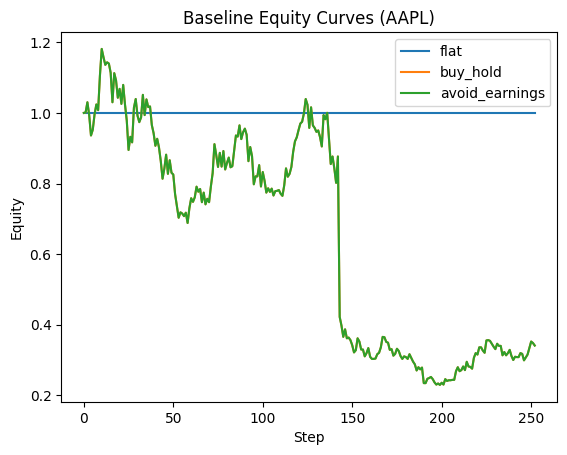

In [12]:
plt.figure()
for r in results:
    plt.plot(r["equity_curve"], label=r["policy"])
plt.title("Baseline Equity Curves (AAPL)")
plt.xlabel("Step")
plt.ylabel("Equity")
plt.legend()
plt.show()

## Optional: multi-symbol smoke test

We run a few baseline episodes across multiple symbols to ensure:
- No crashes from missing data
- Episode logic works across tickers
- Features are consistently available

This is a final robustness check before PPO training.

In [13]:
rng = np.random.default_rng(0)
test_syms = ["AAPL", "MSFT", "JPM"]

multi = []
for sym in test_syms:
    env = TradingEnv(seed=123, symbols=[sym])
    multi.append(run_episode(env, policy="buy_hold"))

pd.DataFrame([{
    "symbol": r["symbol"],
    "final_equity": r["final_equity"],
    "max_drawdown": r["max_drawdown"]
} for r in multi])

,symbol,final_equity,max_drawdown
0,AAPL,1.458060,0.307745
1,MSFT,1.594218,0.221003
2,JPM,1.103024,0.463426


## Summary

At this point we have confirmed:
- TradingEnv imports correctly from `src/`
- Observations, rewards, and termination behave as expected
- Environment is deterministic when seeded
- Baseline strategies run end-to-end without errors

Next:
Notebook 03 will evaluate PPO against these baselines using
matched episodes and out-of-sample symbols.